# Graph neural network for predicting NMR chemical shifts

This Collab is the code and a pre-trained model to predict NMR chemical shifts from protein structures and organic molecules from a graph neural network.

[Github Repo](https://github.com/ur-whitelab/nmrgnn/)


**You should not trust peaks coming from model without checking**

## Citation

Please cite [Predicting Chemical Shifts with Graph Neural Networks](https://doi.org/10.1101/2020.08.26.267971)

```bibtex
@article{yang2020predicting,
  title     = {Predicting Chemical Shifts with Graph Neural Networks},
  author    = {Yang, Ziyue and Chakraborty, Maghesree and White, Andrew D},
  journal   = {bioRxiv},
  year      = {2020},
  publisher = {Cold Spring Harbor Laboratory}
}
```
## Model Performance

[See here](https://github.com/ur-whitelab/nmrgnn/blob/master/README.md#model-performance)


In [4]:
#@title Install Dependncies
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:

      # Install OpenMM and pdbfixer.
      %shell rm -rf /opt/conda
      %shell wget -q -P /tmp \
        https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
          && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
          && rm /tmp/Miniconda3-latest-Linux-x86_64.sh
      pbar.update(10)

      PATH=%env PATH
      %env PATH=/opt/conda/bin:{PATH}
      %shell conda update -qy conda \
          && conda install -qy -c conda-forge \
            python=3.7 \
            openmm=7.5.1 \
            pdbfixer
      pbar.update(50)
      %shell python -m pip install nmrgnn@git+git://github.com/ur-whitelab/nmrgnn.git pandas
      pbar.update(10)
      %shell python -m pip install "nmrdata[parse] @ git+git://github.com/ur-whitelab/nmrdata.git"
      pbar.update(15)
      # MDanalysis problem?
      %shell python -m pip uninstall -y numpy && pip install numpy
      pbar.update(15)
except subprocess.CalledProcessError:
  print(captured)
  raise

In [45]:
#@title Choose input PDB
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  pdb_input = fn

Saving ASN_unrelaxed_model_1.pdb to ASN_unrelaxed_model_1 (3).pdb


In [67]:
#@title Compute Chemical Shifts
job = pdb_input.split('.pdb')[0]
pdb_output = f'{job}-clean.pdb'
csv_output = f'{job}-shifts.csv'

%shell nmrparse clean-pdb $pdb_input $pdb_output
%shell nmrgnn eval-struct $pdb_output $csv_output


2021-07-23 01:19:25.399585: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
/opt/conda/lib/python3.7/site-packages/nmrdata/loading.py:308: UserWarning: Guessing the system dimensions are[149.07901001 104.88899994 146.75        90.          90.
  90.        ]
  'Guessing the system dimensions are' + str(dimensions))


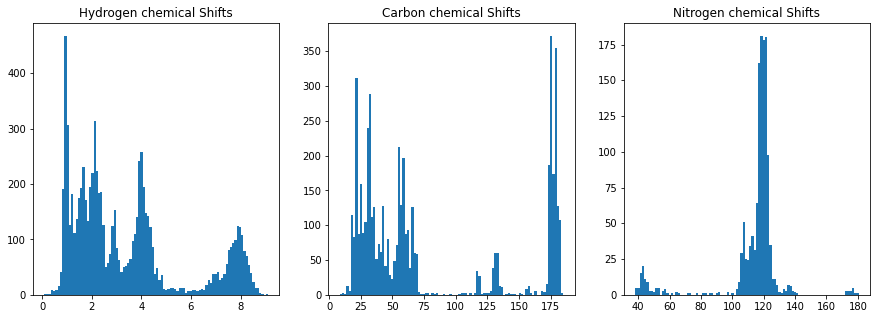

In [68]:
#@title Visualize Results
#@markdown Histograms of predicted chemical shifts
import sys
sys.path.append('/opt/conda/lib/python3.7/site-packages')
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(csv_output)
data.head()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title('Hydrogen chemical Shifts')
axs[0].hist(data[data.names.str.startswith('H')].peaks, bins=100)
axs[1].set_title('Carbon chemical Shifts')
axs[1].hist(data[data.names.str.startswith('C')].peaks, bins=100)
axs[2].set_title('Nitrogen chemical Shifts')
axs[2].hist(data[data.names.str.startswith('N')].peaks, bins=100)
plt.show()


In [65]:
#@title Download CSV of Predicted Shifts
from google.colab import files
files.download(csv_output) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
#@title Download Processed PDB used for Shift Prediction
from google.colab import files
files.download(pdb_output) 